# Access Planet Fusion data via Sentinel Hub

This notebook shows how the Planet Fusion datasets can be accessed via [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/). The service allows you to programmatically access imagery over a given bounding box and time-interval, as well as download statistics over the single geometries defining agricultural fields. 

To use Sentinel Hub you require an account. If you don't have one already, you can create [here](https://www.sentinel-hub.com/) a trial account for a month, or <a href="mailto:info@sentinel-hub.com">contact support</a> to enable access to the datasets for the entire duration of the challenge.

In [1]:
from collections import defaultdict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sentinelhub import (
    BBox, Geometry, CRS, SHConfig,
    SentinelHubCatalog,
    SentinelHubRequest, DataCollection, MimeType,
    SentinelHubStatistical,
    parse_time, bbox_to_dimensions
)

Please set-up your Sentinel Hub credentials, uncomment and fill in below. Check [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request.html) for more information.

In [2]:
config = SHConfig()
# config.sh_client_id = ''
# config.sh_client_secret = ''

The following Evalscript sets up the function executed when downloading the Planet Fusion images. In this case, the four spectral bands are downloaded in the `data` file, while the QA bands are downloaded in the `qa` file.

In [3]:
pf_evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{"bands": ["SR1", "SR2", "SR3", "SR4", "QA1", "QA2", "QA3", "QA4", "QA5", "QA6", "QA7", "QA8", "QA9"]}],
    output: [
       {id: "data", bands: 4, sampleType: SampleType.UINT16},
       {id: "qa", bands: 9, sampleType: SampleType.UINT16}
    ]
  }
}

function evaluatePixel(sample) {
  return {
    'data': [sample.SR1, sample.SR2, sample.SR3, sample.SR4],
    'qa': [sample.QA1, sample.QA2, sample.QA3, sample.QA4, sample.QA5, sample.QA6, sample.QA7, sample.QA8, sample.QA9]
  }
}
"""

## DataCollections

The Planet Fusion datasets have been ingested separately into collections for Germany and South Africa, as well as for training and testing, to make it easier to retrieve the data you desire.

1-day-revisit collections:

 * South Africa
     * training: `5095865e-1e14-48bc-9a9d-393654821344`
     * testing: `4a2c6921-1f76-4735-8712-44714ed76661`
 * Germany 
     * training: `d34c54be-4b69-44a0-885b-bf06cf6eb106`
     * testing: `f3f18eb2-ee88-44ac-bcb9-829259d214a9`

In [4]:
south_africa_train_1d = DataCollection.define_byoc('5095865e-1e14-48bc-9a9d-393654821344')
south_africa_test_1d = DataCollection.define_byoc('4a2c6921-1f76-4735-8712-44714ed76661')

germany_train_1d = DataCollection.define_byoc('d34c54be-4b69-44a0-885b-bf06cf6eb106')
germany_test_1d = DataCollection.define_byoc('f3f18eb2-ee88-44ac-bcb9-829259d214a9')

5-day mosaic collections: 

 * South Africa
     * training: `d6718868-68a2-46fd-9798-ed77e0f306f4`
     * testing: `afca330f-b5b6-4046-8431-ec4c3f4a18c1`
 * Germany
     * training: `b10805ea-616f-4e4c-ade9-4135922a8e95`
     * testing: `e0e8f74f-d0c3-4bd3-a69d-a964e99330a6`

In [5]:
south_africa_train_5d = DataCollection.define_byoc('d6718868-68a2-46fd-9798-ed77e0f306f4')
south_africa_test_5d = DataCollection.define_byoc('afca330f-b5b6-4046-8431-ec4c3f4a18c1')

germany_train_5d = DataCollection.define_byoc('b10805ea-616f-4e4c-ade9-4135922a8e95')
germany_test_5d = DataCollection.define_byoc('e0e8f74f-d0c3-4bd3-a69d-a964e99330a6')

## Catalog API request

For each of the collections above you can retrieve information about the file it contains, specifically:

 * the time interval over which the files are defined;
 * the geographic extent of the tiles.

In [6]:
catalog = SentinelHubCatalog(config=config)

Specify here the collection you want ot inspect.

In [7]:
sa_iterator = catalog.search(south_africa_train_1d, bbox=BBox((-180, -90, 180, 90), CRS.WGS84), time=None)

Retrieve information.

In [8]:
sa_df = gpd.GeoDataFrame.from_features(list(sa_iterator), crs='epsg:4326')

In [9]:
sa_df.head()

,geometry,datetime,proj:epsg,proj:bbox,proj:geometry
0,"MULTIPOLYGON (((20.78293 -34.19681, 20.78348 -...",2017-11-30T00:00:00Z,32734,"[455999.99999999884, 6216000.000045238, 479999...","{'crs': {'type': 'name', 'properties': {'name'..."
1,"MULTIPOLYGON (((20.78237 -34.41326, 20.78293 -...",2017-11-30T00:00:00Z,32734,"[455999.99999999866, 6192000.0000419365, 48000...","{'crs': {'type': 'name', 'properties': {'name'..."
2,"MULTIPOLYGON (((20.78293 -34.19681, 20.78348 -...",2017-11-29T00:00:00Z,32734,"[455999.99999999884, 6216000.000045238, 479999...","{'crs': {'type': 'name', 'properties': {'name'..."
3,"MULTIPOLYGON (((20.78237 -34.41326, 20.78293 -...",2017-11-29T00:00:00Z,32734,"[455999.99999999866, 6192000.0000419365, 48000...","{'crs': {'type': 'name', 'properties': {'name'..."
4,"MULTIPOLYGON (((20.78293 -34.19681, 20.78348 -...",2017-11-28T00:00:00Z,32734,"[455999.99999999884, 6216000.000045238, 479999...","{'crs': {'type': 'name', 'properties': {'name'..."


### time interval

In [10]:
sa_df.datetime.min(), sa_df.datetime.max()

('2017-04-01T00:00:00Z', '2017-11-30T00:00:00Z')

### total bounds

In [11]:
sa_df.total_bounds

array([ 20.52121575, -34.41325604,  20.78347751, -33.97963341])

## Plot test 

Let's plot an image over a smaller bounding box.

**NOTE**: if you wanted to get images over the entire time-period, repeat the following `request` specifying each date in time interval.

In [12]:
def get_extent(bbox):
    """ Calculate the extent (bounds) of the bounding box. """
    return bbox.min_x, bbox.max_x, bbox.min_y, bbox.max_y


def plot_data(data, bbox, viz_factor=2.5, label=None):
    """ Utility function to plot True color and False color images """
    fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
    ax[0].imshow(np.clip(viz_factor * data[..., [2, 1, 0]] / 10000., 0, 1), extent=get_extent(bbox))
    ax[0].set_title("RGB image")
    if label is not None:
        label.boundary.plot(ax=ax[0], color='y')

    ax[1].imshow(np.clip(viz_factor * data[..., [3, 1, 0]] / 10000., 0, 1), extent=get_extent(bbox))
    ax[1].set_title("False color image")
    if label is not None:
        label.boundary.plot(ax=ax[1], color='y')

In [13]:
# index from dataframe
idx = 0

# retrieve bbox from properties and make it smaller
bbox = BBox(sa_df.iloc[idx]['proj:bbox'], crs=CRS(int(sa_df.iloc[idx]['proj:epsg'])))
bbox = bbox.buffer(-0.95)

# retrieve datetime
time_interval = sa_df.iloc[idx].datetime

request = SentinelHubRequest(
    evalscript=pf_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=south_africa_train_1d,
        time_interval=time_interval
    )],
    responses=[
        SentinelHubRequest.output_response('data', MimeType.TIFF),
        SentinelHubRequest.output_response('qa', MimeType.TIFF)
    ],
    bbox=bbox,
    size=bbox_to_dimensions(bbox, 3.0),
    data_folder='test_data',
    config=config
)

response = request.get_data(save_data=True)[0]

data = response['data.tif']
qa = response['qa.tif']

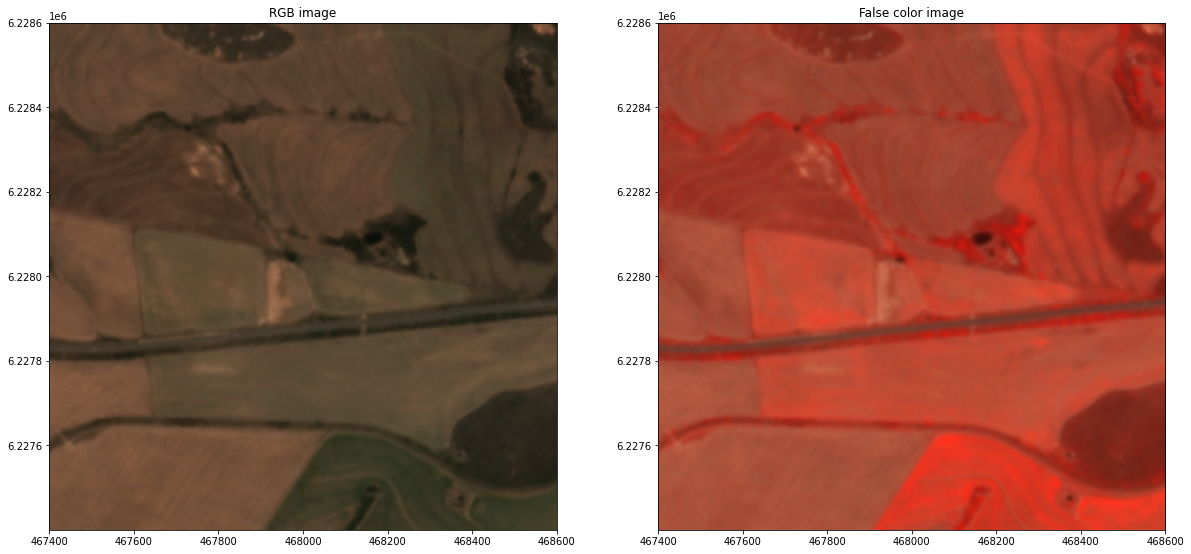

In [14]:
plot_data(data, bbox)

## Plot an agricultural field 

We can repeat the above but download images for a given agricultural parcel only.

The following code assumes you have downloaded from Radiant Earth's MLHub the training labels for South Africa.

In [15]:
labels = gpd.read_file(
    'ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_258N/labels.geojson')

In [16]:
labels.iloc[0]

fid                                                       80172
SHAPE_AREA                                              86608.8
SHAPE_LEN                                               2165.33
crop_id                                                       4
crop_name                                        Lucerne/Medics
geometry      (POLYGON ((456686.5518827988 6215911.790400274...
Name: 0, dtype: object

In [17]:
field_id = 80172

# retrieve bbox from a field
bbox = BBox(labels[labels.fid == field_id].iloc[0].geometry.bounds, crs=CRS(labels.crs.to_epsg()))

# retrieve datetime
time_interval = sa_df.iloc[idx].datetime

request = SentinelHubRequest(
    evalscript=pf_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=south_africa_train_1d,
        time_interval=time_interval
    )],
    responses=[
        SentinelHubRequest.output_response('data', MimeType.TIFF),
        SentinelHubRequest.output_response('qa', MimeType.TIFF)
    ],
    bbox=bbox,
    size=bbox_to_dimensions(bbox, 3.0),
    data_folder='test_data',
    config=config
)

response = request.get_data(save_data=True)[0]

data = response['data.tif']
qa = response['qa.tif']

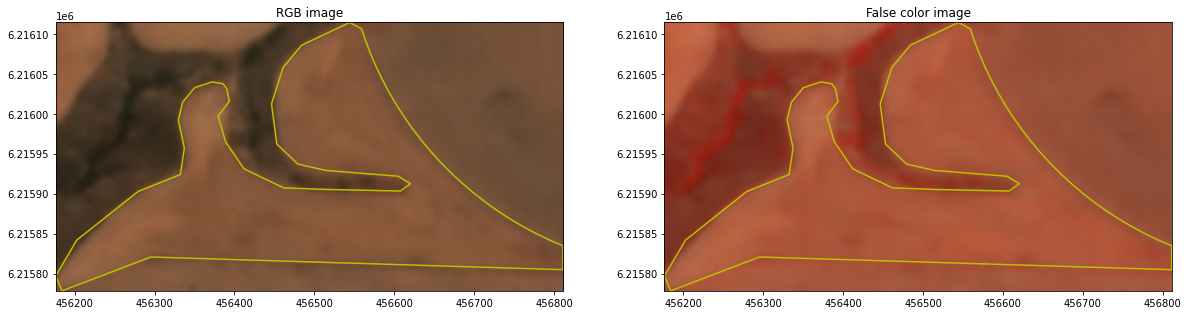

In [18]:
plot_data(data, bbox, label=labels[labels.fid == field_id])

## Statistical API 

Sentinel Hub allows you also to retrieve statistic over a geometry rather than the pixels of the image. This greatly reduces the amount of data you will be working with. The following code shows you how to use the `StatisticalAPI` to achieve this.

In [19]:
def stat_to_df(stat_data):
    """ transform response from StatAPI into dataframe"""
    df_data = defaultdict(list)

    for single_data in stat_data['data']:
        df_data['interval_from'].append(parse_time(single_data['interval']['from']).date())
        df_data['interval_to'].append(parse_time(single_data['interval']['to']).date())

        for output_data in single_data['outputs'].keys():
            for band_name, band_values in single_data['outputs'][output_data]['bands'].items():
                for stat_name, value in band_values['stats'].items():
                    col_name = f'{output_data}_{band_name}_{stat_name}'
                    if stat_name == 'percentiles':
                        for perc, perc_val in value.items():
                            perc_col_name = f'{col_name}_{perc}'
                            df_data[perc_col_name].append(perc_val)
                    else:
                        df_data[col_name].append(value)

    df = pd.DataFrame(df_data)
    return df

As above, this evalscript defines which operations are executed on the raw bands before statistics are applied. 

In this case we retrieve the four bands and compute the NDVI index. The valid data mask is also returned.

You can modify this script if you wanted to retrieve statistics on different indices derived from the raw bands.

In [20]:
stat_evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{"bands": ["SR1", "SR2", "SR3", "SR4"]}],
    output: [
       { 
          id: "data", 
          bands: ["SR1", "SR2", "SR3", "SR4"], 
          sampleType: SampleType.UINT16
       },
       {
          id: "indices",
          bands: ["NDVI"],
          sampleType: SampleType.FLOAT32
       },
       {
          id: "dataMask", 
          bands: 1, 
          sampleType: SampleType.UINT8
       }
    ]
  }
}

function evaluatePixel(sample) {
  let NDVI = index(sample.SR4, sample.SR3)
  var dataMask = 0
  if (sample.SR1 > 0) {
    dataMask = 1
  }
  return {
    data: [sample.SR1, sample.SR2, sample.SR3, sample.SR4],
    indices: [NDVI],
    dataMask: [dataMask]
  }
}
"""

Define parameters for the statistical API request.

The request will return the following statistics:

 * `min`: minimum value over the pixels withing the provided geometry
 * `max`: maximum value over the pixels withing the provided geometry
 * `mean`: mean value over the pixels withing the provided geometry
 * `stdDev`: standard deviation value over the pixels withing the provided geometry
 * `sampleCount`: number of samples/pixels used to compute the statistics
 * `noDataCount`: number of ignored samples/pixels

In [21]:
aggregation = SentinelHubStatistical.aggregation(
    evalscript=stat_evalscript,
    time_interval=(sa_df.datetime.min(), sa_df.datetime.max()),
    aggregation_interval='P1D',
    resolution=(3, 3) # PF resolution
)

input_data = SentinelHubStatistical.input_data(
    south_africa_train_1d
)

In [22]:
request = SentinelHubStatistical(
    aggregation=aggregation,
    input_data=[input_data],
    geometry=Geometry(labels[labels.fid == field_id].iloc[0].geometry, crs=CRS(labels.crs.to_epsg())),
    config=config
)

In [23]:
response = request.get_data()[0]

In [24]:
stats = stat_to_df(response)

In [25]:
stats.head()

,interval_from,interval_to,indices_NDVI_min,indices_NDVI_max,indices_NDVI_mean,indices_NDVI_stDev,indices_NDVI_sampleCount,indices_NDVI_noDataCount,data_SR2_min,data_SR2_max,...,data_SR4_mean,data_SR4_stDev,data_SR4_sampleCount,data_SR4_noDataCount,data_SR3_min,data_SR3_max,data_SR3_mean,data_SR3_stDev,data_SR3_sampleCount,data_SR3_noDataCount
0,2017-04-01,2017-04-02,0.078835,0.343057,0.134074,0.022372,23744,13715,758.0,1663.0,...,2560.117559,116.362161,23744,13715,1001.0,2384.0,1957.952039,139.579346,23744,13715
1,2017-04-02,2017-04-03,0.084254,0.339090,0.134612,0.021385,23744,13715,768.0,1651.0,...,2561.876757,111.622786,23744,13715,1010.0,2364.0,1956.995613,134.937287,23744,13715
2,2017-04-03,2017-04-04,0.083521,0.337923,0.134500,0.021468,23744,13715,768.0,1644.0,...,2560.056536,110.055490,23744,13715,1010.0,2351.0,1956.054542,133.994917,23744,13715
3,2017-04-04,2017-04-05,0.084047,0.334851,0.135124,0.021133,23744,13715,776.0,1644.0,...,2558.273906,106.852458,23744,13715,1016.0,2334.0,1952.103600,131.001662,23744,13715
4,2017-04-05,2017-04-06,0.083617,0.333333,0.135710,0.021076,23744,13715,784.0,1644.0,...,2562.531259,103.350778,23744,13715,1026.0,2321.0,1952.962309,128.839922,23744,13715


Plot the mean DN value for the four bands.

Text(0.5, 0, 'Time interval')

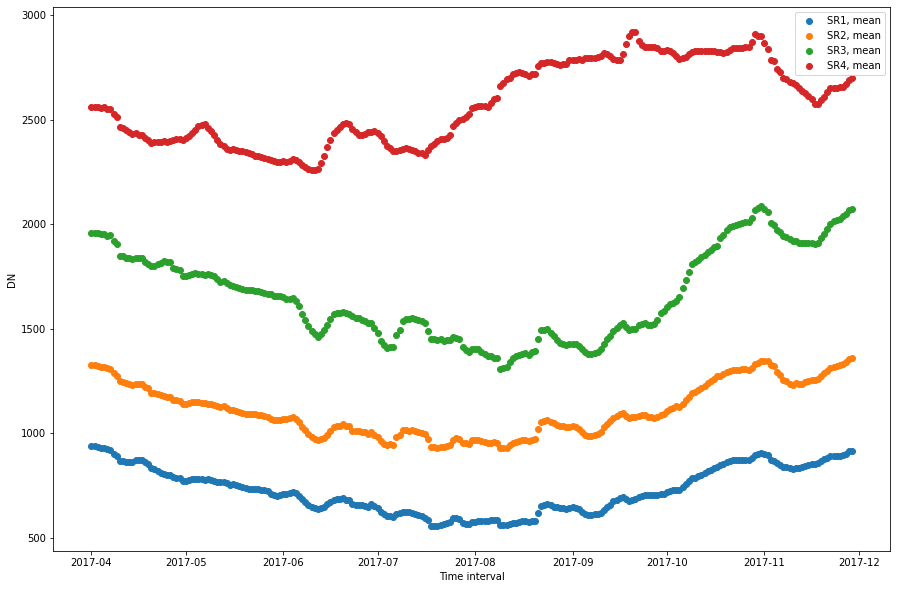

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot_date(x=stats.interval_from, y=stats.data_SR1_mean, label='SR1, mean')
ax.plot_date(x=stats.interval_from, y=stats.data_SR2_mean, label='SR2, mean')
ax.plot_date(x=stats.interval_from, y=stats.data_SR3_mean, label='SR3, mean')
ax.plot_date(x=stats.interval_from, y=stats.data_SR4_mean, label='SR4, mean')
ax.legend()
ax.set_ylabel('DN')
ax.set_xlabel('Time interval')

You can apply the same logic to download time-series for Sentinel-2 and Sentinel-1 as well, as shown in this example below.

For more details and examples about Statistical API, consult the [documentation](https://docs.sentinel-hub.com/api/latest/api/statistical/).

In [27]:
s2_stat_evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{"bands": ["B04", "B08", "dataMask", "CLP"]}],
    output: [
       { 
          id: "indices", 
          bands: ["NDVI"], 
          sampleType: SampleType.FLOAT32
       },
       {
          id: "dataMask", 
          bands: 1, 
          sampleType: SampleType.UINT8
       }
    ]
  }
}

function evaluatePixel(sample) {
  let NDVI = index(sample.B08, sample.B04)
  let dM = sample.dataMask
  let cloudProbability = sample.CLP / 255.
  if (cloudProbability > 0.3) {
     dM = 0
  }
  return {
    'indices': [NDVI],
    'dataMask': [dM]
  }
}
"""

In [28]:
s2_aggregation = SentinelHubStatistical.aggregation(
    evalscript=s2_stat_evalscript,
    time_interval=(sa_df.datetime.min(), sa_df.datetime.max()),
    aggregation_interval='P1D',
    resolution=(10, 10) # S2 resolution
)

s2_input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL2_L2A # specify here which data collection you want
)

In [29]:
s2_request = SentinelHubStatistical(
    aggregation=s2_aggregation,
    input_data=[s2_input_data],
    geometry=Geometry(labels[labels.fid == field_id].iloc[0].geometry, crs=CRS(labels.crs.to_epsg())),
    config=config
)

In [30]:
s2_response = s2_request.get_data()[0]
s2_stats = stat_to_df(s2_response)

In [31]:
s2_stats.head()

,interval_from,interval_to,indices_NDVI_min,indices_NDVI_max,indices_NDVI_mean,indices_NDVI_stDev,indices_NDVI_sampleCount,indices_NDVI_noDataCount
0,2017-04-01,2017-04-02,0.0916442,0.344067,0.136356,0.0301172,2176,1182
1,2017-04-08,2017-04-09,0.0571071,0.365359,0.103942,0.0361086,2176,1255
2,2017-04-11,2017-04-12,0.0716228,0.372194,0.115654,0.0352219,2176,1182
3,2017-04-18,2017-04-19,0.0572687,0.401949,0.11157,0.0426142,2176,1182
4,2017-04-21,2017-04-22,0.0763819,0.377564,0.122016,0.0396241,2176,1182


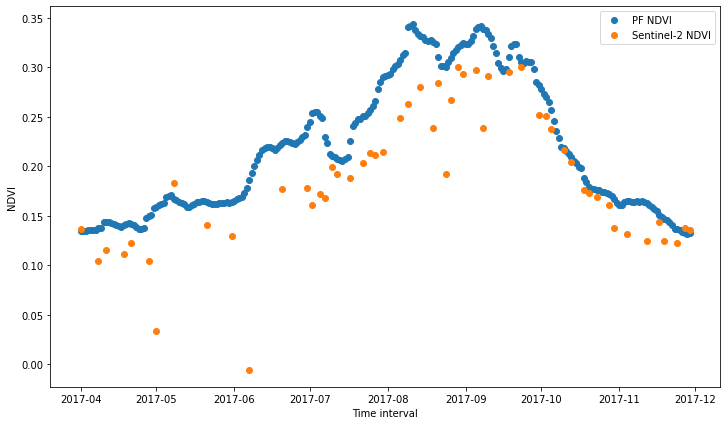

In [32]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot_date(x=stats.interval_from, y=stats.indices_NDVI_mean, label='PF NDVI')
ax.plot_date(x=s2_stats.interval_from, y=s2_stats.indices_NDVI_mean, label='Sentinel-2 NDVI')
ax.legend()
ax.set_ylabel('NDVI')
ax.set_xlabel('Time interval');